In [1]:
from data_import import *
from data_preprocess import *

In [2]:
NLP_TOPIC_RECOGNITION_FILEPATH = '../NLP Topic Recognition'
NLP_MODEL_FILEPATH = '../NLP Model Training/model_100K_glove'
TEXTUAL_RAW_DATA_FILEPATH = '../Data/textual_raw'

OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_filtered_2g_user_weights.csv"

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(NLP_TOPIC_RECOGNITION_FILEPATH)
from topic_recognition import *
#from NLP_class import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [4]:
from tensorflow import keras
model = keras.models.load_model(NLP_MODEL_FILEPATH)

In [5]:
def get_users(paths):
    df = pd.DataFrame()
    for path in paths:
        text_data = preprocess_textual(path)
        df = pd.concat([df, text_data])

    ini_set = set(df['username'].values)
    #initialized as neutral (0.5) and 1 occurance
    users = dict.fromkeys(ini_set, (0.5,1))
    return users

def user_update(username, sentiment):
    #update
    (s,t) = users[username]
    (s_new, t_new) = (s + sentiment, t + 1)
    users[username] = (s_new, t_new)
    
    #sentiment calculation
    sentiment_weighted = sentiment - s/t
    return sentiment_weighted

In [6]:
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]
i = 1
df = pd.DataFrame()
btc_data = preprocess_BTC()
# _, flagged_usernames = flag_users()
flagged_usernames = []
start = timer()

users = get_users(paths)

for path in paths:
#     if i<21:
#         i+=1
#         continue
    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)
    
#     old
#     timetable = topic_recognition(text_data, flagged_usernames = [], display = message)
#     print(timetable)

    text = NLP_preprocess(text_data)
    text.preprocess_data()
    text.spam_filtering()
    

    #print(text.df.iloc[0], text.df.iloc[-1]['date'][:-2] + '00')
    
    text.import_tokenizer()
    df_padded = text.tokenize_and_pad(train = False)
    
    text.df["sentiment"] = (model.predict(df_padded))
    #print(text.df.index)
    
    #try: weight messeges by the average optimism/pessimism of each user
    #this might have an impact because there are about 5.5 messages per user,
    #so there is some history about them
    text.df['weighted'] = text.df.index.map(lambda x: user_update(text.df.loc[x]['username'],  text.df.loc[x]['sentiment'])) 
    print(text.df)
    
    text.df["hour"] =  text.df.date.map(lambda x: x[:-6])
#     timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    
    timetable = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
    timetable2 = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    
    timetable = timetable[:-1]
    timetable2 = timetable2[:-1]
    
    btc_connected = connect_datasets(text.df, btc_data)[1:]
    
    i += 1
    
    if len(timetable.index) != len(btc_connected.index):
        continue
        
    timetable.index = btc_connected.index
    timetable2.index = btc_connected.index
    
    timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['Open']], axis = 1)
    #print(timetable)
    df = pd.concat([df, timetable], axis = 0)
    #print(df)
df.to_csv(OUTPUT_DATASET_FILEPATH)
print(timer() - start)


Iterration 1 of 65
             username                 date retweets favorites  \
0             jcmarqz  2017-09-13 23:59:59        0         0   
1              nmoryl  2017-09-13 23:59:59        0         2   
2      bfsi_financial  2017-09-13 23:59:39        0         0   
3      williams_simon  2017-09-13 23:59:37        0         1   
4      TopFiveTraders  2017-09-13 23:59:35        0         0   
...               ...                  ...      ...       ...   
38154   cryptonirvana  2017-09-13 00:00:02        0         0   
38155      rbcgamnews  2017-09-13 00:00:01        2         1   
38156    CryptoHourly  2017-09-13 00:00:00        0         0   
38157    CryptoHourly  2017-09-13 00:00:00        0         0   
38158         icoanar  2017-09-13 00:00:00        2         2   

                                                    text geo  \
0      bitcoin ai beijing startup poised challenge li...       
1                                 everyone else rbitcoin       
2      j

Iterration 4 of 65
           username                 date retweets favorites  \
0         Coinbelly  2017-10-07 23:59:56        0         0   
1          koska752  2017-10-07 23:59:51        0         0   
2     Bitcoin_Spain  2017-10-07 23:59:35        0         1   
3     Bitcoin_Spain  2017-10-07 23:59:34        0         1   
4       bitcoinpoet  2017-10-07 23:59:34        0         2   
...             ...                  ...      ...       ...   
2456      EslingerA  2017-10-07 20:52:18        0         1   
2457      GreySkyCp  2017-10-07 20:52:18        0         1   
2458    GoldCoinJar  2017-10-07 20:52:04        0         1   
2459   stone22stone  2017-10-07 20:52:03        0         0   
2460      maf_store  2017-10-07 20:52:01        1         0   

                                                   text geo       mentions  \
0     bitcoin meets netflix laolu building lightning...                      
1     bit fun play games fun earn bitcoin … bitcoin ...      @bitfun

Iterration 7 of 65
             username                 date retweets favorites  \
0           Coinbelly  2017-10-13 23:59:55        0         0   
1           Ausbiznet  2017-10-13 23:59:41        0         1   
2       BAutotradings  2017-10-13 23:59:40        0         2   
3       CryptoNewsBot  2017-10-13 23:59:35        1         0   
4        Cryptocredit  2017-10-13 23:59:30        0         0   
...               ...                  ...      ...       ...   
42741   cryptonirvana  2017-10-13 00:00:02        0         0   
42742    CryptoHourly  2017-10-13 00:00:02        0         0   
42743       coinstats  2017-10-13 00:00:02        1         0   
42744       kuriharan  2017-10-13 00:00:01        0         1   
42745  BTCBillionsBot  2017-10-13 00:00:00        0         0   

                                                    text geo       mentions  \
0      bitcoin price analysis bitcoin rally shows str...                      
1      bitcoin buy citizenship one happies

Iterration 10 of 65
              username                 date retweets favorites  \
0          BtcEthereum  2017-11-13 23:59:56        0         0   
1            WhitesPhD  2017-11-13 23:59:54        0         1   
2        BullTrapMerch  2017-11-13 23:59:52        0         1   
3               slygag  2017-11-13 23:59:50        0         1   
4       ZarkMuckerbarn  2017-11-13 23:59:47        0         1   
...                ...                  ...      ...       ...   
43816  whatchuuumeannn  2017-11-13 00:00:00        0         4   
43817     CryptoHourly  2017-11-13 00:00:00        0         0   
43818       top_3_coin  2017-11-13 00:00:00        0         0   
43819        Coinbelly  2017-11-13 00:00:00        0         0   
43820   BTCBillionsBot  2017-11-13 00:00:00        0         0   

                                                    text geo   mentions  \
0      bitcoin cash hard forks blockchain bid ease mi...                  
1             two cents whats going b

Iterration 13 of 65
              username                 date retweets favorites  \
0        SamuelPower39  2017-11-30 23:59:56        1         2   
1      TheBitcoinFight  2017-11-30 23:59:55        0         0   
2           VPMConnect  2017-11-30 23:59:53        0         0   
3           VPMConnect  2017-11-30 23:59:47        0         0   
4        theautomatski  2017-11-30 23:59:45        0         0   
...                ...                  ...      ...       ...   
72203   SourceAmyChin1  2017-11-30 00:00:01        0         0   
72204     CryptoHourly  2017-11-30 00:00:01        0         0   
72205     CryptoHourly  2017-11-30 00:00:00        0         0   
72206       top_3_coin  2017-11-30 00:00:00        1         0   
72207   BTCBillionsBot  2017-11-30 00:00:00        0         0   

                                                    text geo mentions  \
0      usually lower name calling people since idiot ...                
1          us favor make sure mention bca

Iterration 16 of 65
             username                 date retweets favorites  \
0        ItsRyanBates  2017-12-14 23:59:57        0         3   
1           Coinbelly  2017-12-14 23:59:56        0         0   
2           Evilagram  2017-12-14 23:59:55        0         0   
3         Skeppy_PVP_  2017-12-14 23:59:52        0         0   
4      Fairfields9963  2017-12-14 23:59:50        0         0   
...               ...                  ...      ...       ...   
70684    CryptoHourly  2017-12-14 00:00:00        0         0   
70685      vicecanada  2017-12-14 00:00:00        3         6   
70686    CryptoHourly  2017-12-14 00:00:00        0         0   
70687      top_3_coin  2017-12-14 00:00:00        0         0   
70688  BTCBillionsBot  2017-12-14 00:00:00        0         0   

                                                    text geo  mentions  \
0      much better time buy you’re looking buy hold n...                 
1      japans gmo internet group pay thousands work

Iterration 19 of 65
              username                 date retweets favorites  \
0      crypto_monopoly  2018-01-21 23:59:57        0         2   
1          bitcoinbase  2018-01-21 23:59:54        0         0   
2      Bitcoin_NewsBTC  2018-01-21 23:59:52        0         0   
3              twitgel  2018-01-21 23:59:50        0         0   
4          NhaNguyen48  2018-01-21 23:59:48        0         1   
...                ...                  ...      ...       ...   
40438       top_3_coin  2018-01-21 00:00:00        0         1   
40439      CesareCorso  2018-01-21 00:00:00        0         0   
40440     IdentityMind  2018-01-21 00:00:00        0         0   
40441       CryptoGulp  2018-01-21 00:00:00        0         0   
40442   BTCBillionsBot  2018-01-21 00:00:00        0         0   

                                                    text geo mentions  \
0              call “chip” cause love dip crypto bitcoin                
1                                sell bit

Iterration 22 of 65
             username                 date retweets favorites  \
0         xCryptoLove  2018-03-15 23:59:59        0         0   
1          AlertTrade  2018-03-15 23:59:56        0         0   
2        Swahilipages  2018-03-15 23:59:52        0         0   
3         StartupWide  2018-03-15 23:59:50        0         0   
4       TheReal_KDubb  2018-03-15 23:59:48        0         0   
...               ...                  ...      ...       ...   
48988    CryptoHourly  2018-03-15 00:00:00        0         0   
48989      top_3_coin  2018-03-15 00:00:00        0         0   
48990      CryptoGulp  2018-03-15 00:00:00        1         0   
48991  BTCBillionsBot  2018-03-15 00:00:00        0         0   
48992   discordguilds  2018-03-15 00:00:00        0         0   

                                                    text geo mentions  \
0      longshort bitcoin volatility 100x leverage bit...                
1      voucher 10 btgbtc bitcoin gold hodl hodl hodl 

Iterration 25 of 65
             username                 date retweets favorites  \
0          rCryptoBot  2018-04-08 23:59:57        0         0   
1      ABS_SH_TPOSTER  2018-04-08 23:59:54        0         3   
2      digitaltechnow  2018-04-08 23:59:49        0         0   
3          BytesOfMan  2018-04-08 23:59:46        0         0   
4          viabitcoin  2018-04-08 23:59:35        0         0   
...               ...                  ...      ...       ...   
34557      top_3_coin  2018-04-08 00:00:00        0         0   
34558      ahmedjr_16  2018-04-08 00:00:00        6         8   
34559  BTCBillionsBot  2018-04-08 00:00:00        0         0   
34560      CryptoGulp  2018-04-08 00:00:00        0         0   
34561   discordguilds  2018-04-08 00:00:00        0         0   

                                                    text geo mentions  \
0      new post withdrawing bitcoin … cryptocurrency ...                
1      monex’s coincheck vs mt gox traditional financ

Iterration 27 of 65
              username                 date retweets favorites  \
0               ocohen  2018-05-08 23:59:59        0         0   
1       WorldCoinIndex  2018-05-08 23:59:51        0         0   
2      repofromtheedge  2018-05-08 23:59:49        0         0   
3           LaminSwann  2018-05-08 23:59:43        0         0   
4         graham_afful  2018-05-08 23:59:35        0         0   
...                ...                  ...      ...       ...   
40071     aads_network  2018-05-08 00:00:00        0         0   
40072        kuriharan  2018-05-08 00:00:00        0         3   
40073   BTCBillionsBot  2018-05-08 00:00:00        0         0   
40074       CryptoGulp  2018-05-08 00:00:00        0         1   
40075       top_3_coin  2018-05-08 00:00:00        0         0   

                                                    text geo        mentions  \
0           ill less tweet bitcoin bitcoin cash isnt get                       
1      bitcoin price index 

Iterration 30 of 65
              username                 date retweets favorites  \
0          Shahkar0110  2018-05-13 23:59:55        1         9   
1               jawnsy  2018-05-13 23:59:44        0         1   
2      El_Crypto_Chapo  2018-05-13 23:59:43        0         3   
3        TheReal_KDubb  2018-05-13 23:59:43        0         0   
4              luo2027  2018-05-13 23:59:41        0         1   
...                ...                  ...      ...       ...   
30032      v_vashishta  2018-05-13 00:00:00        4         3   
30033        Utoday_en  2018-05-13 00:00:00        1         2   
30034  CryptoTopCharts  2018-05-13 00:00:00        0         1   
30035   BTCBillionsBot  2018-05-13 00:00:00        0         0   
30036       top_3_coin  2018-05-13 00:00:00        0         1   

                                                    text geo mentions  \
0      bytecoin daily binnce yesterday formed hammer ...                
1      something something bitcoin someth

Iterration 33 of 65
              username                 date retweets favorites  \
0           BlakeMabry  2018-05-22 23:59:51        0         0   
1      Remi_Vladuceanu  2018-05-22 23:59:46        5         8   
2             torusJKL  2018-05-22 23:59:43        0         0   
3          muzammil381  2018-05-22 23:59:43        0         0   
4             Nobadbro  2018-05-22 23:59:41        1         2   
...                ...                  ...      ...       ...   
35107       top_3_coin  2018-05-22 00:00:00        1         1   
35108        cryptoros  2018-05-22 00:00:00        0         1   
35109  BitFinance_News  2018-05-22 00:00:00        0         0   
35110   BTCBillionsBot  2018-05-22 00:00:00        0         0   
35112       CryptoGulp  2018-05-22 00:00:00        0         0   

                                                    text geo mentions  \
0      new post pizza day celebration ticket blockcha...                
1      litecoin ltc price watch triangle 

Iterration 36 of 65
              username                 date retweets favorites  \
0      ExcitingWorld32  2018-06-15 23:59:56        0         0   
1         cryptist0071  2018-06-15 23:59:44        0         0   
2       SteinLudvigsen  2018-06-15 23:59:38        2        22   
3      ronsmithmipower  2018-06-15 23:59:27        0         2   
4          nataIiefina  2018-06-15 23:59:26        0         0   
...                ...                  ...      ...       ...   
31314    cryptonirvana  2018-06-15 00:00:01        0         0   
31315     CryptoHourly  2018-06-15 00:00:00        0         0   
31316       top_3_coin  2018-06-15 00:00:00        0         0   
31317   BTCBillionsBot  2018-06-15 00:00:00        0         0   
31318       CryptoGulp  2018-06-15 00:00:00        0         0   

                                                    text geo  mentions  \
0      liked youtube video crypto market manipulation...      @YouTube   
1      i’ve crypto scene since late 201

Iterration 39 of 65
             username                 date retweets favorites  \
1        RippleFuture  2018-07-02 23:59:46        1         3   
2        antiprosynth  2018-07-02 23:59:46        0         0   
3       EncryptedCoin  2018-07-02 23:59:44        0         4   
4      CryptoBloggCOM  2018-07-02 23:59:43        0         0   
5               BIAUS  2018-07-02 23:59:39        0         0   
...               ...                  ...      ...       ...   
28818  InfoProNetwork  2018-07-02 00:00:01        0         0   
28819       coinstats  2018-07-02 00:00:01        0         0   
28820    CryptoHourly  2018-07-02 00:00:00        0         0   
28821      CryptoGulp  2018-07-02 00:00:00        0         0   
28822  BTCBillionsBot  2018-07-02 00:00:00        0         0   

                                                    text geo        mentions  \
1      ripple greatest team onboard succeed crypto co...                       
2      launching bitcoin clones differe

Iterration 42 of 65
              username                 date retweets favorites  \
0        msarybsarstee  2018-07-17 23:59:58        0         0   
1       GPSTrackerShop  2018-07-17 23:59:51        0         1   
2      faith65ktgking2  2018-07-17 23:59:50        0         0   
3         sOfritoCoins  2018-07-17 23:59:40        0         0   
4              osm_nbt  2018-07-17 23:59:36        0         0   
...                ...                  ...      ...       ...   
33743     CryptoHourly  2018-07-17 00:00:01        0         0   
33744    John_Blockium  2018-07-17 00:00:01        0         0   
33745       CryptoGulp  2018-07-17 00:00:00        0         0   
33746   BTCBillionsBot  2018-07-17 00:00:00        0         0   
33747    AltcoinTicker  2018-07-17 00:00:00        0         0   

                                                    text   geo  \
0      longshort bitcoin moves 100x leverage bitmex g...  None   
1                    bitcoin accepted gps tracker shop 

Iterration 44 of 65
             username                 date retweets favorites  \
0             pornada  2018-07-21 23:59:57        0         0   
1          fetisavran  2018-07-21 23:59:55        0         1   
2      foolishdweller  2018-07-21 23:59:52        0         0   
3        rusathlsarry  2018-07-21 23:59:48        0         0   
4        BigDaddyMafi  2018-07-21 23:59:46        1         0   
...               ...                  ...      ...       ...   
24684    CryptoHourly  2018-07-21 00:00:00        0         0   
24685     maransa2006  2018-07-21 00:00:00        0         0   
24686  Dallas61739789  2018-07-21 00:00:00        0         0   
24687      CryptoGulp  2018-07-21 00:00:00        0         0   
24688  BTCBillionsBot  2018-07-21 00:00:00        0         0   

                                                    text  \
0                     would fun hear keynes take bitcoin   
1      bitcoin bittrexexchange bitfinex binance czbin...   
2                  

Iterration 46 of 65
             username                 date retweets favorites  \
0             osm_nbt  2018-08-07 23:59:53        0         0   
1          workin2005  2018-08-07 23:59:47        0         1   
2       douglaskphoto  2018-08-07 23:59:34        0         0   
3      CryptosWithB66  2018-08-07 23:59:30        0         0   
4       douglaskphoto  2018-08-07 23:59:25        0         0   
...               ...                  ...      ...       ...   
27784          tictoc  2018-08-07 00:00:01        4        13   
27785  InfoProNetwork  2018-08-07 00:00:01        0         0   
27786    CryptoHourly  2018-08-07 00:00:00        0         0   
27787      CryptoGulp  2018-08-07 00:00:00        0         0   
27788  BTCBillionsBot  2018-08-07 00:00:00        0         0   

                                                    text geo      mentions  \
0      another major investment firm says bitcoin etf...                     
1      ripple xrp daily buysell signals pri

Iterration 49 of 65
              username                 date retweets favorites  \
0           Airdropfre  2018-08-23 23:59:59        0         0   
1      MonacoSophiaBiz  2018-08-23 23:59:54        2         1   
2           jbruhaha94  2018-08-23 23:59:53        0         0   
3        StanislawMatt  2018-08-23 23:59:51        0         0   
4            emmmperor  2018-08-23 23:59:46        0         1   
...                ...                  ...      ...       ...   
28239  CryptoTopCharts  2018-08-23 00:00:00        0         0   
28240        Cryptopk1  2018-08-23 00:00:00        0         0   
28241   BTCBillionsBot  2018-08-23 00:00:00        0         0   
28242       CryptoGulp  2018-08-23 00:00:00        0         0   
28243    discordguilds  2018-08-23 00:00:00        0         0   

                                                    text geo  \
0      cardonio airdrop cardonio airdropping 200 cdo ...       
1      company thinks help solve bitcoin’s energy pro...   

Iterration 52 of 65
              username                 date retweets favorites  \
0       localcryptobiz  2018-09-20 23:59:54        0         0   
1      Remi_Vladuceanu  2018-09-20 23:59:50        1         4   
2            WaxCrypto  2018-09-20 23:59:46        0         3   
3             4PawShop  2018-09-20 23:59:45        0         1   
4             4PawShop  2018-09-20 23:59:44        0         1   
...                ...                  ...      ...       ...   
25847   InfoProNetwork  2018-09-20 00:00:00        0         0   
25848         BAI_Info  2018-09-20 00:00:00        0         0   
25849       CryptoGulp  2018-09-20 00:00:00        0         0   
25850   BTCBillionsBot  2018-09-20 00:00:00        0         0   
25851    discordguilds  2018-09-20 00:00:00        0         0   

                                                    text geo mentions  \
0      advertise crypto project seen 50k followers tw...       @https   
1      top 6 cryptocurrencies producing n

Iterration 55 of 65
              username                 date retweets favorites  \
0              QuadraQ  2018-10-18 23:59:48        0         0   
1           ndmckinley  2018-10-18 23:59:41        0         0   
2           CoinWireHQ  2018-10-18 23:59:35        0         0   
3             btcradar  2018-10-18 23:59:28        0         0   
4      ConstructnRates  2018-10-18 23:59:21        0         0   
...                ...                  ...      ...       ...   
23854   bitcoinrate247  2018-10-18 00:00:02        0         0   
23855    cryptonirvana  2018-10-18 00:00:02        0         0   
23857     CryptoHourly  2018-10-18 00:00:00        0         0   
23858       CryptoGulp  2018-10-18 00:00:00        0         1   
23859   BTCBillionsBot  2018-10-18 00:00:00        0         0   

                                                    text geo mentions  \
0                japanese south korean bitcoin asics win                
1      well entering 11th year since bitc

Iterration 58 of 65
            username                 date retweets favorites  \
0      FreestyIeRaps  2018-12-09 04:01:00    17479     36119   
1        EmilyStrom5  2018-12-16 23:13:58        0         2   
2           foxfox89  2018-12-16 18:27:50       10        54   
3       oluwaloninyo  2018-12-16 12:49:28     1580      2395   
4      theaudreyjane  2018-12-16 13:56:17       25        48   
...              ...                  ...      ...       ...   
16833      rBitcoins  2018-12-04 08:15:09        0         0   
16834    GreshamINTL  2018-12-04 08:15:06        0         1   
16835    aslammotala  2018-12-04 08:15:05        0         0   
16836   big_blockers  2018-12-04 08:15:02        0         0   
16837       castarco  2018-12-04 08:14:57        0         1   

                                                    text  \
0            video always gets mepictwittercomcbynbeg7is   
1                                    sorry happens james   
2      whitehat fanart heroicau

Iterration 60 of 65
              username                 date retweets favorites  \
0           rCryptoBot  2018-12-30 23:59:58        0         0   
1       TrustWalletApp  2018-12-30 23:59:56        0         0   
2      profits_bitcoin  2018-12-30 23:59:56        0         1   
3            bardia514  2018-12-30 23:59:54        1         2   
4          Satterkvist  2018-12-30 23:59:39        0         3   
...                ...                  ...      ...       ...   
19048        coinstats  2018-12-30 00:00:01        0         0   
19049     CryptoHourly  2018-12-30 00:00:00        0         0   
19050    MirrorReview1  2018-12-30 00:00:00        0         0   
19051        kuriharan  2018-12-30 00:00:00        1         3   
19052  profits_bitcoin  2018-12-30 00:00:00        1         2   

                                                    text geo  \
0      new bitcoins value venezuala use … cryptocurre...       
1      trustwalletapp always receive payments without...   

Iterration 63 of 65
              username                 date retweets favorites  \
0      CryptoPressNews  2019-01-14 23:59:59        1         1   
1      profits_bitcoin  2019-01-14 23:59:43        0         2   
2        NotSkycoinCEO  2019-01-14 23:59:43        3        25   
3               derose  2019-01-14 23:59:36        0         0   
4      CryptoContagion  2019-01-14 23:59:34        0         2   
...                ...                  ...      ...       ...   
21995   bitcoinrate247  2019-01-14 00:00:02        0         0   
21996      Thewoolluff  2019-01-14 00:00:02        0         3   
21997   InfoProNetwork  2019-01-14 00:00:01        0         0   
21999        coinstats  2019-01-14 00:00:01        0         1   
22000     CryptoHourly  2019-01-14 00:00:00        0         0   

                                                    text   geo mentions  \
0                                                    btc  None     None   
1      btc fake news russia probably 

Iterration 65 of 65
              username                 date retweets favorites  \
0          DistBrandon  2019-01-22 22:51:29        0         0   
1         ryanunderdev  2019-01-22 22:51:26        0         0   
2      structured_sett  2019-01-22 22:51:18        0         0   
3        aheadsocially  2019-01-22 22:51:01        0         0   
4         CobraBitcoin  2019-01-22 22:50:45        0         2   
...                ...                  ...      ...       ...   
21009        coinstats  2019-01-22 00:00:01        0         0   
21010    cryptonirvana  2019-01-22 00:00:01        0         0   
21011   InfoProNetwork  2019-01-22 00:00:01        0         0   
21012   InfoProNetwork  2019-01-22 00:00:01        0         0   
21013     CryptoHourly  2019-01-22 00:00:00        0         0   

                                                    text geo mentions  \
0      yeah echoing ck said beauty pow it’s hard mine...                
1      except bitcoin developers working 

In [7]:
df

,Bitcoin,Bitcoin_median,Open
2017-09-13 01,0.041773,0.066211,4128.005439
2017-09-13 02,0.051911,0.089798,4066.801167
2017-09-13 03,0.027604,0.052726,3999.225167
2017-09-13 04,0.018836,0.042056,3959.409667
2017-09-13 05,0.076571,0.109514,3995.046667
...,...,...,...
2019-01-22 18,0.030288,0.050931,3584.926897
2019-01-22 19,0.025549,0.053502,3585.858545
2019-01-22 20,0.028746,0.057698,3585.295893
2019-01-22 21,0.034695,0.073557,3579.910755


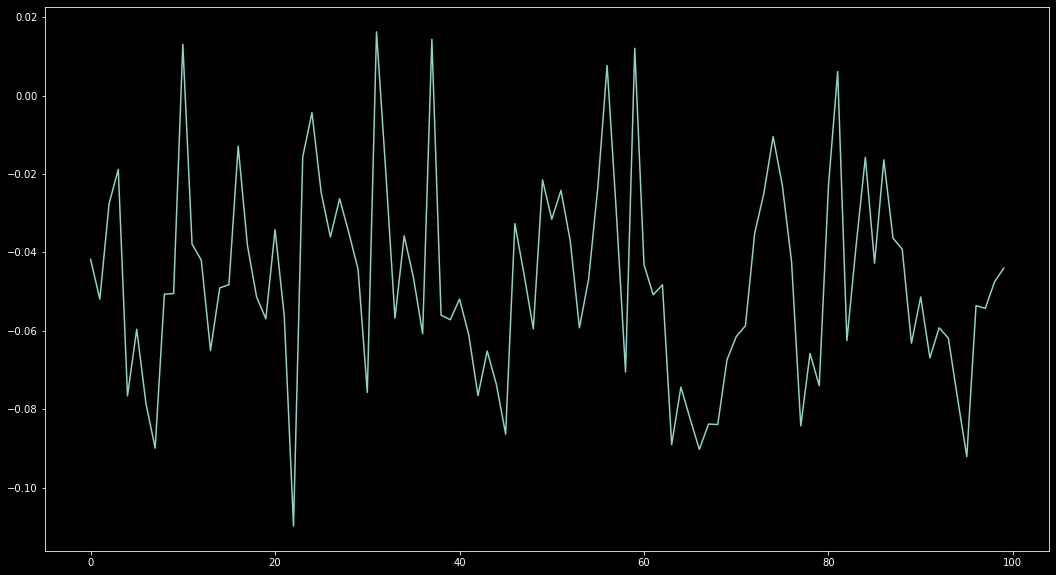

In [25]:
DATASET_FILEPATH = "./Dataset_sentiment_100K_glove_filtered_2g.csv"
df2 = pd.read_csv(DATASET_FILEPATH, index_col = 0)
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), -1*df['Bitcoin'].values[:100])

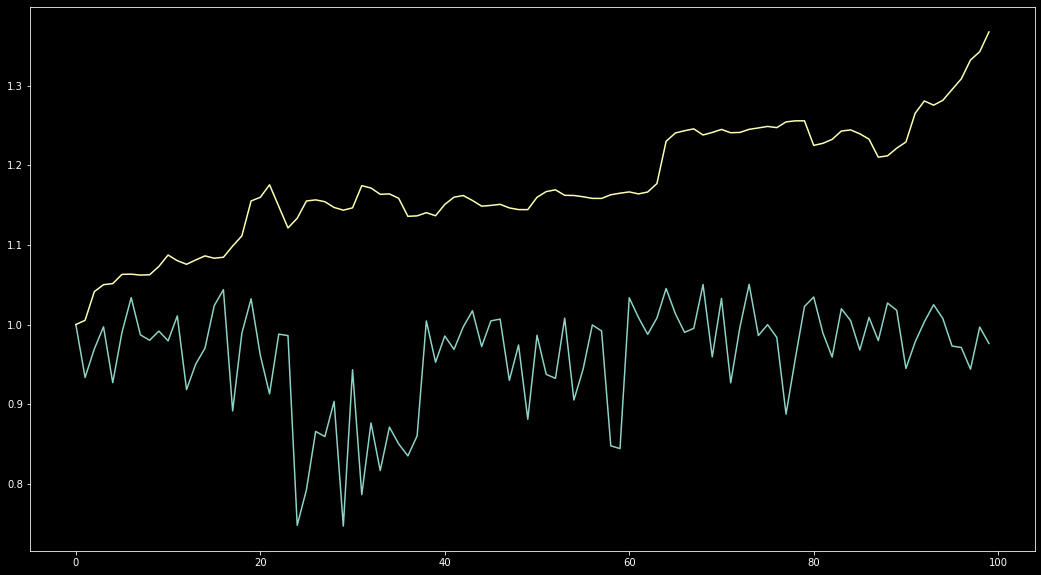

In [62]:
fig = plt.figure(figsize=(18, 10))
x = -df2['Bitcoin'][100:200]
x = x/x[0]
y = df2['Open'][100:200]
y = y/y[0]
plt.plot(range(0,100), x)
plt.plot(range(0,100), y)


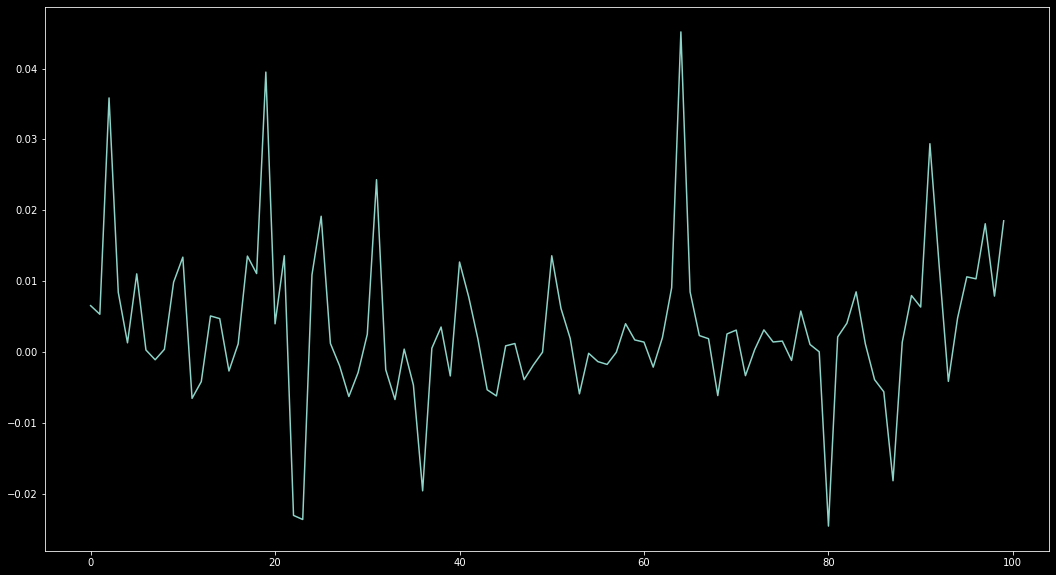

In [28]:
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), df.pct_change()['Open'].values[100:200])

In [ ]:
import random
i = random.randint(0,len(text_data.index))
print(text_data.loc[i]['text'])
print(text_data.loc[i]['sentiment'])

In [50]:
#BTC price data of the next hour standarized
Y = pd.DataFrame(df['Open']).astype(float)
#Y = dataset_standarization(Y)

#Textual data ('Bitcoin' topic popularity) of the last hour standarized
X = pd.DataFrame(df['Bitcoin']).astype(float)
#X = dataset_standarization(X)
Y.index = X.index

X = sm.add_constant(X)

model = sm.OLS(Y, X, missing = 'drop').fit()

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03219
Date:                Wed, 09 Jun 2021   Prob (F-statistic):              0.858
Time:                        20:34:53   Log-Likelihood:                 3273.4
No. Observations:                1427   AIC:                            -6543.
Df Residuals:                    1425   BIC:                            -6532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.010     -0.160      0.873      -0.022       0.019
0              0.0023      0.013      0.179      0.858      -0.023       0.028
==============================================================================
Omnibus:                     1208.658   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1015622.999
Skew:                           2.711   Prob(JB):                         0.00
Kurtosis:                     133.583   Cond. No.                         32.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""